In [1]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import torch
import torch.nn as nn
import torchmetrics
import torchsummary
import torch_training_toolkit as t3
from torch.utils.data import Dataset

print(f"Using Pytorch: {torch.__version__}, torchmetrics: {torchmetrics.__version__}")
print(f"GPU is {'available :)' if torch.cuda.is_available() else 'not available :('}")

SEED = t3.seed_all(t3.T3_FAV_SEED)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Using Pytorch: 1.13.1+cpu, torchmetrics: 0.11.1
GPU is not available :(


In [2]:
def cv2_imshow_(a, **kwargs):
    """ function from Google Colab - display cv2 image inline """
    a = a.clip(0, 255).astype('uint8')
    # cv2 stores colors as BGR; convert to RGB
    if a.ndim == 3:
        if a.shape[2] == 4:
            a = cv2.cvtColor(a, cv2.COLOR_BGRA2RGBA)
        else:
            a = cv2.cvtColor(a, cv2.COLOR_BGR2RGB)

    plt.axis("off")
    return plt.imshow(a, **kwargs)


In [3]:

def cv2_imshow(img, title=None, fig_size=None, show_axis=False, **kwargs):
    """ show cv2 image in a matplotlib plot output window """
    # convert from default BGR to RGB schema
    img = img.clip(0, 255).astype('uint8')
    if (img.ndim == 3) and (img.shape[2] == 4):
        # images with alpha channel
        img = cv2.cvtColor(img, cv2.COLOR_BGRA2RGBA)
    else:
        # all other types, including grayscale
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    if fig_size is not None:
        plt.figure(figsize=fig_size)
    if title is not None:
        plt.title(title)
    if not show_axis:
        plt.axis('off')
    plt.imshow(img, **kwargs)
    plt.show()


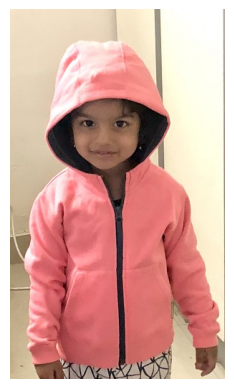

In [4]:
img = cv2.imread("Hemanvi.jpeg")
cv2_imshow(img);

2 (200, 200) 3 (200, 200, 3)


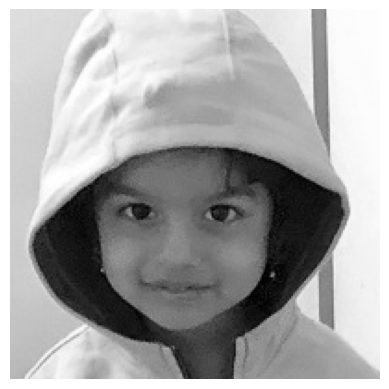

In [5]:
# lets crop the image & display it
img2 = img[50:250, 40:240]
img_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
print(img_gray.ndim, img_gray.shape, img2.ndim, img2.shape)
cv2_imshow(img_gray);

In [6]:
# load the Fashion MNIST dataset
from torchvision import datasets, transforms

xforms = transforms.Compose([
      transforms.ToTensor()
])

download_folder = os.path.join(os.getcwd(), "data")
assert os.path.exists(download_folder), f"FATAL: {download_folder} - PATH does not exist!"

train_dataset = datasets.FashionMNIST(download_folder, train=True, download=True, transform=xforms)
test_dataset = datasets.FashionMNIST(download_folder, train=False, download=True, transform=xforms)

# split test dataset into cross-val & test 
val_dataset, test_dataset = t3.split_dataset(test_dataset, split_perc=0.2)
print(f"Train dataset: {len(train_dataset)} recs - Val dataset: {len(val_dataset)} recs - Test dataset: {len(test_dataset)} recs")


Train dataset: 60000 recs - Val dataset: 8000 recs - Test dataset: 2000 recs


In [7]:
unique_values, class_names = train_dataset.targets.unique(), train_dataset.classes
print(f"Unique labels: {unique_values}\nClass names: {class_names}")

Unique labels: tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
Class names: ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


In [8]:
# display random set of images
def display_sample(images, labels, class_names, sample_predictions=None, plot_title=None):

    plt.style.use("seaborn")
    
    with sns.axes_style("whitegrid"):
        sns.set_context("notebook", font_scale=0.85)

        fig, ax = plt.subplots(8, 8, figsize=(8, 8), squeeze=True)
        fig.tight_layout()
        fig.subplots_adjust(top=0.90)
        for row in range(8):
            for col in range(8):
                index = row * 8 + col
                ax[row, col].axis("off")
                img = images[index]
                # img = img.transpose((1, 2, 0))
                ax[row, col].imshow(img.squeeze(), cmap='Greys', interpolation="nearest")
                label = labels[index]
                ax[row, col].set_title(f"{class_names[label]}")
    plt.suptitle(plot_title)
    plt.show()

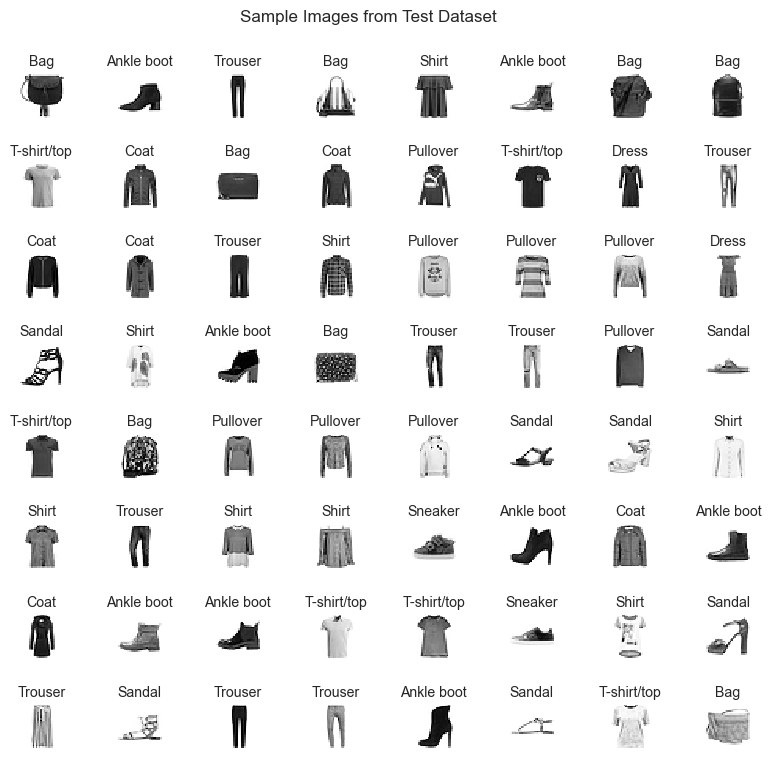

In [9]:
loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=True)
images, labels = next(iter(loader))
class_names = train_dataset.classes
# print(f"images.shape {images.shape} - labels.shape {labels.shape} - classes: {class_names}")
display_sample(images.to("cpu"), labels.to("cpu"), class_names, 
               plot_title="Sample Images from Test Dataset")


In [10]:
# some globals
IMAGE_HEIGHT, IMAGE_WIDTH, NUM_CHANNELS, NUM_CLASSES = 28, 28, 1, 10
NUM_EPOCHS, BATCH_SIZE, LEARNING_RATE, L2_REG = 50, 128, 0.001, 0.04
PY_MODEL_SAVE_PATH = os.path.join(os.getcwd(), "model_states", "fashion_mnist.pt")
print(f"Model will be saved to {PY_MODEL_SAVE_PATH}")


Model will be saved to c:\Dev\Code\git-projects\dl-pytorch\model_states\fashion_mnist.pt


In [11]:
# define the model
class Net(nn.Module):
    def __init__(self, image_dim, num_classes):
        super(Net, self).__init__()
        h, w, c = image_dim
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(h*w*c, 1000),
            nn.ReLU(),
            nn.Linear(1000, num_classes)
        )

    def forward(self, x):
        return self.net(x)

In [12]:
image_dim = (IMAGE_HEIGHT, IMAGE_WIDTH, NUM_CHANNELS)
model = Net(image_dim, NUM_CHANNELS)
#dprint(torchsummary.summary(model, (NUM_CHANNELS, IMAGE_HEIGHT, IMAGE_WIDTH)))
print(model)

Net(
  (net): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=1000, bias=True)
    (2): ReLU()
    (3): Linear(in_features=1000, out_features=1, bias=True)
  )
)


In [13]:
loss_fn = nn.CrossEntropyLoss()
metrics = {
    "acc": torchmetrics.classification.MulticlassAccuracy(num_classes=NUM_CLASSES)
}
trainer = t3.Trainer(
    loss_fn, device=DEVICE, metrics_map = metrics,
    epochs = NUM_EPOCHS, batch_size = BATCH_SIZE
)

In [65]:
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
hist = trainer.fit(
    model, optimizer, train_dataset, validation_dataset=val_dataset
)
hist.plot_metrics(title="Model Performance")

Cross training on 'cpu' with 60000 training and 8000 cross-validation records...


IndexError: Target 4 is out of bounds.